##### modeling and interpretation notebook--train, test, and conclude
***

# Importing Libraries and Data

In [58]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import Model Specific Libraries

In [59]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import math

### Reopening our cleaned dataframe

In [60]:
pd.set_option('display.max_columns', 999)  # setting to view all columns

with open('data/data-drops.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_drops_df = pickle.load(f)

print("Dataframe successfully imported from pickle.\n\n")
display(data_drops_df.shape)
data_drops_df.head()

Dataframe successfully imported from pickle.




(19322, 16)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,98178,47.5112,-122.257,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,98125,47.7210,-122.319,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,98028,47.7379,-122.233,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,98136,47.5208,-122.393,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,98074,47.6168,-122.045,0


# Questions

We have already found that some predictors could be eliminated, due to their lack of correlation or linearity with the response variable. We also eliminated some variables from our study, due to their collinearity with others.

We can begin investigating our remaining questions by building and testing a model, selecting and eliminating features, and adjusting variable coefficients along the way.

> As a reminder of our remaining basic questions:
1. ~~mean price~~
2. mean price within 20 miles of the city center
3. ~~mean bedrooms of home sales (roomates or rentals)~~
4. ~~which influences price more: the number of bedrooms or the number of square feet~~
5. ~~do renovations make a significant difference in such a competitive market~~


We may have already answered question 5, but we will let the model decide for sure.

# Correlations
### Seeing where we stand

In [61]:
# creating a correlations table with absolute values
dd_corr = data_drops_df.corr()

Tthe dataframe can be visually ordered to be more useful. We can order the columns by the strength of their correlation with price, so that is what we will do.

### Sorting columns in order of correlation with `price`

In [62]:
# instantiating a sorted correlation
dd_sort_ix = dd_corr.sort_values(
    'price', ascending=False).index

# creating a variable for sorted correlation indexes
dd_sortix = data_drops_df.loc[:, dd_sort_ix]

### Viewing the sorted correlations table

In [63]:
# view without `id`
dds = dd_sortix.drop(['id'], axis=1).corr()

# view the correlations table
dds

,price,grade,sqft_living,bathrooms,lat,bedrooms,floors,Sqft_basement,view,Renovated,sqft_lot,condition,waterfront,long
price,1.000000,0.618932,0.609295,0.434373,0.413889,0.290800,0.270389,0.226851,0.200093,0.105261,0.070791,0.054149,0.024650,0.010399
grade,0.618932,1.000000,0.699486,0.613053,0.107739,0.335893,0.472663,0.057838,0.110132,0.000614,0.110850,-0.158711,0.010195,0.195652
sqft_living,0.609295,0.699486,1.000000,0.709376,0.033682,0.611205,0.366256,0.349491,0.129183,0.037033,0.202151,-0.060647,0.006378,0.250404
bathrooms,0.434373,0.613053,0.709376,1.000000,-0.000954,0.491025,0.520187,0.210283,0.071480,0.030984,0.036630,-0.130666,0.002532,0.230994
lat,0.413889,0.107739,0.033682,-0.000954,1.000000,-0.036622,0.037467,0.122920,0.015593,0.029110,-0.061206,-0.008453,-0.006727,-0.144036
bedrooms,0.290800,0.335893,0.611205,0.491025,-0.036622,1.000000,0.168740,0.272649,0.036044,0.010425,0.109847,0.028922,-0.009423,0.143168
floors,0.270389,0.472663,0.366256,0.520187,0.037467,0.168740,1.000000,-0.286285,-0.007517,-0.000451,-0.121772,-0.268026,0.000495,0.126038
Sqft_basement,0.226851,0.057838,0.349491,0.210283,0.122920,0.272649,-0.286285,1.000000,0.154804,0.049206,0.029763,0.184148,0.011890,-0.178279
view,0.200093,0.110132,0.129183,0.071480,0.015593,0.036044,-0.007517,0.154804,1.000000,0.038026,0.024076,0.035759,0.058646,-0.080293
Renovated,0.105261,0.000614,0.037033,0.030984,0.029110,0.010425,-0.000451,0.049206,0.038026,1.000000,0.006567,-0.055597,0.021866,-0.057528


We can easily see by column location that `grade` is most strongly correlated with price, followed by `sqft_living`. The weakest correlation to price and the furthest column is longitude, followed by `waterfront`. We can inspect this visually as a heatmap.

In [64]:
# create a function to generate a heatmap
def plot_corr_heatmap(cor, cmap="BuPu"):
    # creating a figure to plot a heatmap from correlations
    plt.figure(figsize=(21,18))
    sns.set(font_scale=1.5, color_codes=True) # making annotations legible
    # plotting
    sns.heatmap(cor.round(2).abs(), center=.8, annot=True, cmap="YlGnBu")
    plt.tick_params(axis="both", which="both", bottom=False, top=True,    
                labelbottom=False, labeltop=True,left=True, 
                    right=False, labelleft=True)
    plt.xticks(rotation = 70, fontsize=20)
    plt.yticks(fontsize=20)
    plt.autoscale() # prevent cropping
    plt.show()

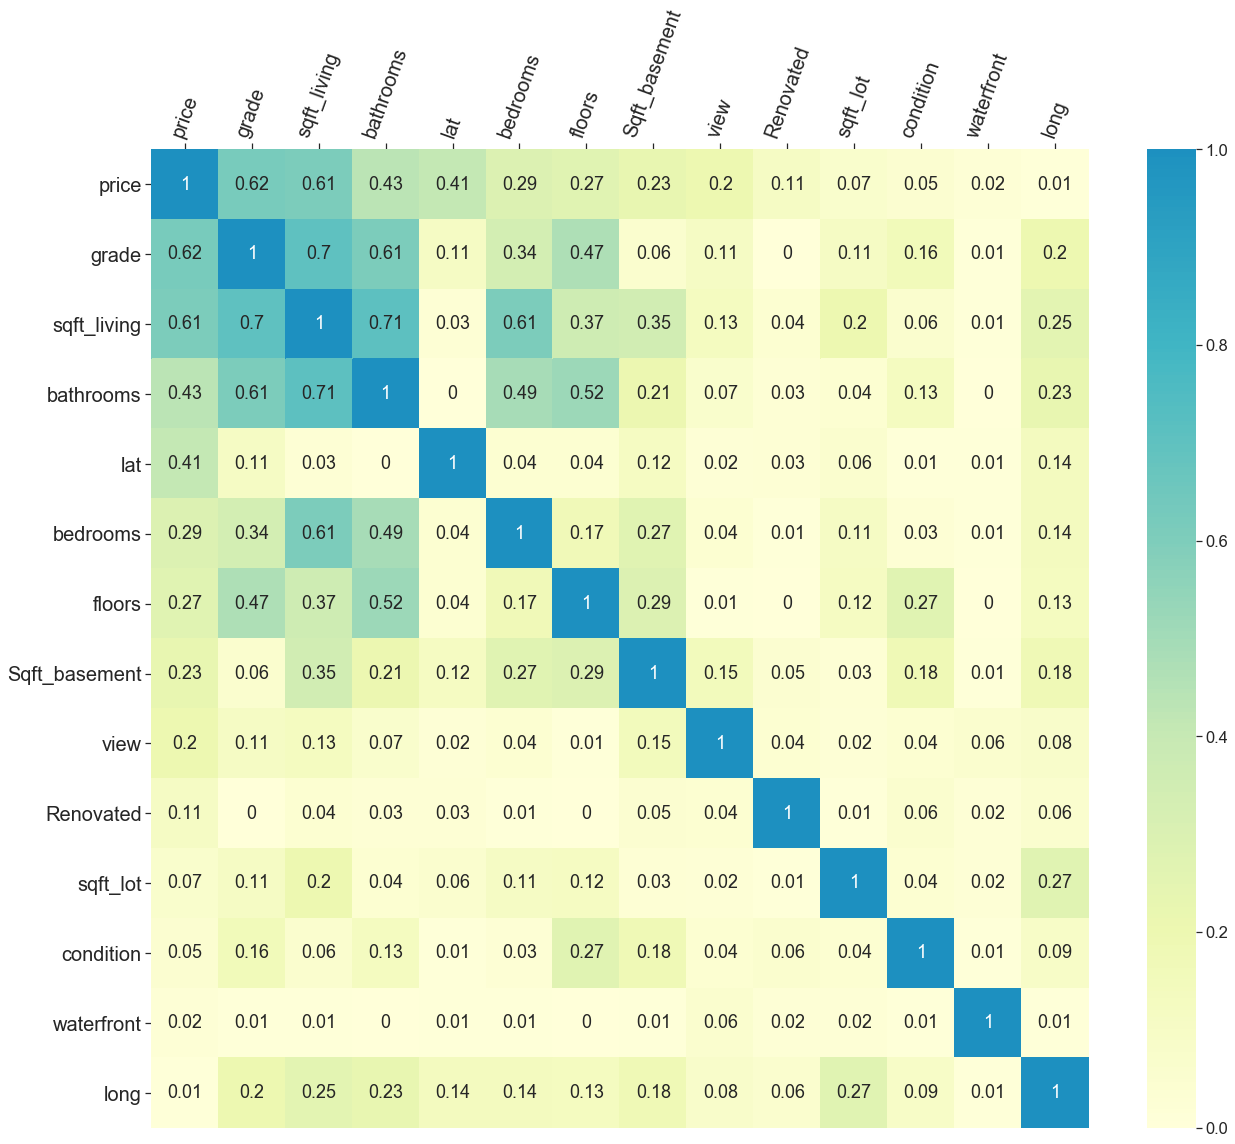

In [65]:
plot_corr_heatmap(dds)

This is a fairly clear indicator that `grade` and `sqft_living` are strong predictors. We also note, however, that the two appear to be strongly collinear. In addition, each appears to be strongly collinear with `bathrooms`, the next strongest feature.

In consideration of processing time, we can at this point eliminate a few weak predictors for price. At the risk of contradicting myself, and at the expense of my curiosity, I think it is fair to eliminate anything below 0.1: that comprises `long`, `waterfront`, `condition`, and `sqft_lot`.

## Dropping weak correlations

We will copy a new dataframe for modeling and testing.

In [66]:
# time to drop that `id` column
data_drops_df.drop('id', axis=1, inplace=True)

# creating `mod_df` as a copy of `data_drops_df`
mod_df = data_drops_df.copy()

# viewing first rows
mod_df.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,98178,47.5112,-122.257,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,98125,47.7210,-122.319,1


In [67]:
# removing the `long`, `waterfront`, `condition`, and `sqft_lot` columns
mod_df.drop(['long', 'waterfront', 'condition', 'sqft_lot'], axis=1, inplace=True)

mod_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view',
       'grade', 'Sqft_basement', 'zipcode', 'lat', 'Renovated'],
      dtype='object')

I fully expected that I would drop `Sqft_basement`, but it is not as closely correlate with `sqft_living` as I anticipated, so it stays.

# Modeling Raw Features

Let's get to those modeling and testing libraries.

We can set a baseline, with features as they are. Then we will make any adjustments that appear promising and see whether they improve the model.

In [68]:
# instantiate an empty list
feats = []

# add the dataframe column names to the list without `price`
feats.extend(list(mod_df.columns)[1:])

# view the list of feature names
feats

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'view',
 'grade',
 'Sqft_basement',
 'zipcode',
 'lat',
 'Renovated']

Let's hold off on all the zip codes

In [69]:
# remove `zipcode` from the `feats` list
feats.pop(7)

'zipcode'

In [70]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = feats
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3189.
Date:                Fri, 28 Feb 2020   Prob (F-statistic):               0.00
Time:                        10:48:22   Log-Likelihood:            -2.5833e+05
No. Observations:               19322   AIC:                         5.167e+05
Df Residuals:                   19312   BIC:                         5.168e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.009e+07    3.9e+05    -77.106      0.000   -3.09e+07   -2.93e+07
bedrooms      -1.137e+04   1707.713     -6.660      0.000   -1.47e+04   -8026.825
bathrooms     -1.434e+04   2620.024     -5.474      0.000   -1.95e+04   -9207.677
sqft_living     135.6304      3.012     45.027      0.000     129.726     141.535
floors        -5330.3180   2839.828     -1.877      0.061   -1.09e+04     235.991
view           6.308e+04   2808.620     22.459      0.000    5.76e+04    6.86e+04
grade          8.023e+04   1709.571     46.929      0.000    7.69e+04    8.36e+04
Sqft_basement    13.2492      3.764      3.520      0.000       5.871      20.627
lat             6.26e+05   8231.777     76.051      0.000     6.1e+05    6.42e+05
Renovated      1.085e+05   6483.613     16.731      0.000    9.58e+04    1.21e+05
==============================================================================
Omnibus:                     8954.284   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91716.704
Skew:                           1.971   Prob(JB):                         0.00
Kurtosis:                      12.919   Cond. No.                     7.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The ols model's R-squared suggests that 59.8\% of the variance in `price` can be explained by our model. All p - values are low, with only one exception. Great!

> But, wait.
* The warning indicates strong multicollinearity (very strong, in fact).
* We have a skew of 1.971. We want it to be near zero.
* Kurtosis measures 12.919. We want it near 3.

We saw correlation above 0.7 for `sqft_living` and `grade` and between `sqft_living` and `bathrooms`. I am tempted to see what happens when we remove two of these predictors at a time, leaving just one of them in the model. Two of the three variables are categorical, though. Perhaps we should one - hot encode them, first.

Note: `bedrooms`, `floors`, `view`, and `zipcode` each can be encoded, as well. We will start with `bathrooms` and `grade`.

In [71]:
# copy all data to a new dataframe for encoding
hot_mod_df = mod_df.copy()

## Binning

There are more than a dozen unique values in the `bathrooms` column. Before encoding, we should segment the columns values into fewer bins.

To manage the half- and quarter- baths, we can bin this feature in the style '.5' for less than 1, '1' for homes with at least one and fewer than two bathroom(s), etc..

In [72]:
# what unique values do we currently have?
hot_mod_df.sort_values(by='bathrooms').bathrooms.unique()

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25])

Currently, we have 15 unique values. Binning should reduce this to 4.

In [73]:
# creating the binned column, exclusive of 0 and inclusive of 4
bath_bins = pd.cut(hot_mod_df.bathrooms, 
                   bins=[0, .9, 1.9, 2.9, 3.9, 4], 
                   labels=['partial','1',
                           '2','3', '4'])
#insert the binned next to `bathrooms` column
hot_mod_df.insert(3,'Baths', bath_bins)

In [74]:
# view some rows with various bathroom counts
pd.set_option('display.max_rows', 20)
display(hot_mod_df.iloc[70:77, :])

# display bin column data type
hot_mod_df.Baths.dtype

,price,bedrooms,bathrooms,Baths,sqft_living,floors,view,grade,Sqft_basement,zipcode,lat,Renovated
81,360000.0,4,2.50,2,1900,2.0,0,7,0,98038,47.3490,0
82,355000.0,2,1.00,1,2020,1.0,0,7,1010,98118,47.5474,0
83,356000.0,3,1.50,1,1680,1.0,0,8,0,98059,47.4811,0
84,315000.0,3,1.00,1,960,1.0,0,6,0,98125,47.7264,0
85,940000.0,3,1.50,1,2140,2.0,0,9,240,98119,47.6337,0
86,305000.0,5,2.25,2,2660,1.5,0,7,0,98092,47.2909,0
87,461000.0,3,3.25,3,2770,2.0,0,9,790,98056,47.5228,0


CategoricalDtype(categories=['partial', '1', '2', '3', '4'], ordered=True)

## One - hot Encoding

In [75]:
# dropping the `bathrooms` column
hot_mod_df.drop('bathrooms', axis=1, inplace=True)

# list names of columns to encode
hot_list = ['Baths', 'grade']

# generate dummies for listed columns
for col in hot_list:
    hot_mod_df = pd.concat([hot_mod_df, 
                            pd.get_dummies(hot_mod_df[col], # create columns
                                           prefix=col #use source column name as prefix
                                          )], axis=1
                          ).drop([col], axis=1) # drop source column

In [76]:
# viewing first rows with new columns
hot_mod_df.head()

,price,bedrooms,sqft_living,floors,view,Sqft_basement,zipcode,lat,Renovated,Baths_partial,Baths_1,Baths_2,Baths_3,Baths_4,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
0,221900.0,3,1180,1.0,0,0,98178,47.5112,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,538000.0,3,2570,2.0,0,400,98125,47.7210,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,180000.0,2,770,1.0,0,0,98028,47.7379,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,604000.0,4,1960,1.0,0,910,98136,47.5208,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,510000.0,3,1680,1.0,0,0,98074,47.6168,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [77]:
hot_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19322 entries, 0 to 21596
Data columns (total 24 columns):
price            19322 non-null float64
bedrooms         19322 non-null int64
sqft_living      19322 non-null int64
floors           19322 non-null float64
view             19322 non-null int64
Sqft_basement    19322 non-null int64
zipcode          19322 non-null object
lat              19322 non-null float64
Renovated        19322 non-null int64
Baths_partial    19322 non-null uint8
Baths_1          19322 non-null uint8
Baths_2          19322 non-null uint8
Baths_3          19322 non-null uint8
Baths_4          19322 non-null uint8
grade_3          19322 non-null uint8
grade_4          19322 non-null uint8
grade_5          19322 non-null uint8
grade_6          19322 non-null uint8
grade_7          19322 non-null uint8
grade_8          19322 non-null uint8
grade_9          19322 non-null uint8
grade_10         19322 non-null uint8
grade_11         19322 non-null uint8
grade_12  

In [83]:
# trying the model with the encoded columns
kicks = [col for col in hot_mod_df.columns if col != 'zipcode']
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=hot_mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.143e+31
Date:                Fri, 28 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:02:37   Log-Likelihood:             3.7727e+05
No. Observations:               19322   AIC:                        -7.545e+05
Df Residuals:                   19299   BIC:                        -7.543e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.657e-10   2.11e-09     -0.221      0.825    -4.6e-09    3.66e-09
price             1.0000   3.82e-17   2.62e+16      0.000       1.000       1.000
bedrooms      -5.775e-11   8.94e-12     -6.458      0.000   -7.53e-11   -4.02e-11
sqft_living    7.905e-14   1.64e-14      4.831      0.000     4.7e-14    1.11e-13
floors        -1.774e-11   1.46e-11     -1.211      0.226   -4.64e-11     1.1e-11
view           4.502e-11   1.47e-11      3.053      0.002    1.61e-11    7.39e-11
Sqft_basement  1.021e-13   1.97e-14      5.173      0.000    6.34e-14    1.41e-13
lat           -7.276e-12   4.88e-11     -0.149      0.882   -1.03e-10    8.84e-11
Renovated     -1.255e-10   3.39e-11     -3.707      0.000   -1.92e-10   -5.91e-11
Baths_partial -3.929e-10   2.02e-10     -1.942      0.052    -7.9e-10    3.71e-12
Baths_1       -7.276e-11   1.73e-10     -0.420      0.675   -4.13e-10    2.67e-10
Baths_2        4.802e-10   1.72e-10      2.785      0.005    1.42e-10    8.18e-10
Baths_3        2.328e-10   1.73e-10      1.347      0.178   -1.06e-10    5.72e-10
Baths_4        1.164e-09   2.08e-10      5.592      0.000    7.56e-10    1.57e-09
grade_3        -1.31e-09   7.62e-10     -1.719      0.086    -2.8e-09    1.84e-10
grade_4        -5.53e-10   2.71e-10     -2.042      0.041   -1.08e-09   -2.21e-11
grade_5        -2.91e-10   2.35e-10     -1.236      0.216   -7.52e-10     1.7e-10
grade_6        -2.91e-10   2.32e-10     -1.253      0.210   -7.46e-10    1.64e-10
grade_7       -3.783e-10   2.32e-10     -1.630      0.103   -8.33e-10    7.67e-11
grade_8        -5.53e-10   2.32e-10     -2.385      0.017   -1.01e-09   -9.84e-11
grade_9       -5.966e-10   2.31e-10     -2.579      0.010   -1.05e-09   -1.43e-10
grade_10      -3.201e-10   2.32e-10     -1.382      0.167   -7.74e-10    1.34e-10
grade_11      -3.638e-10   2.41e-10     -1.509      0.131   -8.36e-10    1.09e-10
grade_12      -3.492e-10   4.24e-10     -0.824      0.410   -1.18e-09    4.82e-10
==============================================================================
Omnibus:                      680.942   Durbin-Watson:                   0.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              780.385
Skew:                          -0.443   Prob(JB):                    3.48e-170
Kurtosis:                       3.430   Cond. No.                     7.14e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.11e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# um................................!!!!!!!!!!!
*****

An R - squared of 100% seems dubious.

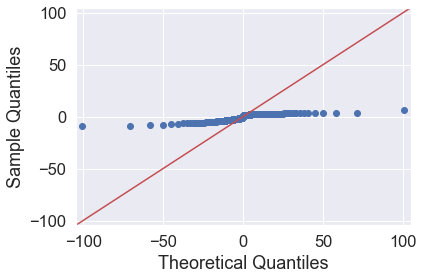

In [84]:
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

In [15]:
# trying the model without `sqft_living` and `grade`
kicks = [f for f in feats if f != 'sqft_living' and f != 'grade']
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     1939.
Date:                Thu, 27 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:28:14   Log-Likelihood:            -2.6199e+05
No. Observations:               19322   AIC:                         5.240e+05
Df Residuals:                   19314   BIC:                         5.241e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.313e+07   4.68e+05    -70.807      0.000    -3.4e+07   -3.22e+07
bedrooms       3.274e+04   1861.932     17.585      0.000    2.91e+04    3.64e+04
bathrooms       1.02e+05   2786.070     36.613      0.000    9.65e+04    1.07e+05
floors         5.206e+04   3351.264     15.535      0.000    4.55e+04    5.86e+04
view           9.235e+04   3372.839     27.380      0.000    8.57e+04     9.9e+04
Sqft_basement    59.4229      4.296     13.831      0.000      51.002      67.844
lat            6.979e+05   9836.721     70.947      0.000    6.79e+05    7.17e+05
Renovated      1.038e+05   7828.239     13.263      0.000    8.85e+04    1.19e+05
==============================================================================
Omnibus:                     8968.656   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86048.045
Skew:                           1.999   Prob(JB):                         0.00
Kurtosis:                      12.534   Cond. No.                     1.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# trying the model without `grade` and `bathrooms`
kicks = [f for f in feats if f != 'grade' and f != 'bathrooms']
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     3396.
Date:                Thu, 27 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:28:22   Log-Likelihood:            -2.5938e+05
No. Observations:               19322   AIC:                         5.188e+05
Df Residuals:                   19314   BIC:                         5.188e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.227e+07   4.08e+05    -79.106      0.000   -3.31e+07   -3.15e+07
bedrooms      -2.289e+04   1766.005    -12.959      0.000   -2.63e+04   -1.94e+04
sqft_living     213.2883      2.423     88.023      0.000     208.539     218.038
floors         1.464e+04   2683.223      5.455      0.000    9377.037    1.99e+04
view           7.141e+04   2958.504     24.138      0.000    6.56e+04    7.72e+04
Sqft_basement   -19.6044      3.842     -5.103      0.000     -27.135     -12.074
lat             6.81e+05   8576.763     79.406      0.000    6.64e+05    6.98e+05
Renovated      9.718e+04   6839.009     14.210      0.000    8.38e+04    1.11e+05
==============================================================================
Omnibus:                     8695.420   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86543.005
Skew:                           1.909   Prob(JB):                         0.00
Kurtosis:                      12.640   Cond. No.                     7.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# trying a model without `bathrooms` and `sqft_living`
kicks = [f for f in feats if f != 'bathrooms' and f != 'sqft_living']
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     3434.
Date:                Thu, 27 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:28:25   Log-Likelihood:            -2.5932e+05
No. Observations:               19322   AIC:                         5.187e+05
Df Residuals:                   19314   BIC:                         5.187e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.902e+07   4.08e+05    -71.113      0.000   -2.98e+07   -2.82e+07
bedrooms       2.476e+04   1545.249     16.026      0.000    2.17e+04    2.78e+04
floors         1.507e+04   2668.634      5.647      0.000    9840.303    2.03e+04
view           6.827e+04   2952.844     23.122      0.000    6.25e+04    7.41e+04
grade          1.249e+05   1403.861     88.954      0.000    1.22e+05    1.28e+05
Sqft_basement    76.9521      3.552     21.665      0.000      69.990      83.914
lat            5.978e+05   8594.565     69.560      0.000    5.81e+05    6.15e+05
Renovated      1.189e+05   6817.578     17.442      0.000    1.06e+05    1.32e+05
==============================================================================
Omnibus:                     8998.000   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90756.406
Skew:                           1.989   Prob(JB):                         0.00
Kurtosis:                      12.844   Cond. No.                     1.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Two of the tested features are discrete (`bathrooms` and `grade`): it may make more sense to one - hot encode them. First, let's see how things look with `zipcode` included (though it will eventually need to be encoded, as well).

In [18]:
# trying the model without `sqft_living` and `grade`
kicks = [f for f in (feats + ['zipcode'])]
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = kicks
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     1016.
Date:                Thu, 27 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:45:19   Log-Likelihood:            -2.5135e+05
No. Observations:               19322   AIC:                         5.029e+05
Df Residuals:                   19243   BIC:                         5.035e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -2.358e+06   2.25e+06     -1.049      0.294   -6.77e+06    2.05e+06
zipcode[T.98002]  2.017e+04   9675.595      2.085      0.037    1207.217    3.91e+04
zipcode[T.98003] -4673.9553   8825.260     -0.530      0.596    -2.2e+04    1.26e+04
zipcode[T.98004]  6.445e+05   1.72e+04     37.545      0.000    6.11e+05    6.78e+05
zipcode[T.98005]  3.349e+05   1.79e+04     18.688      0.000       3e+05     3.7e+05
zipcode[T.98006]  2.655e+05   1.44e+04     18.412      0.000    2.37e+05    2.94e+05
zipcode[T.98007]  2.507e+05   1.81e+04     13.869      0.000    2.15e+05    2.86e+05
zipcode[T.98008]  2.266e+05   1.71e+04     13.284      0.000    1.93e+05     2.6e+05
zipcode[T.98010]   9.53e+04   1.38e+04      6.928      0.000    6.83e+04    1.22e+05
zipcode[T.98011]  1.222e+05   2.34e+04      5.222      0.000    7.63e+04    1.68e+05
zipcode[T.98014]  1.098e+05   2.22e+04      4.953      0.000    6.64e+04    1.53e+05
zipcode[T.98019]  6.797e+04   2.29e+04      2.971      0.003    2.31e+04    1.13e+05
zipcode[T.98022]  1.794e+04   1.14e+04      1.579      0.114   -4324.426    4.02e+04
zipcode[T.98023] -2.196e+04   7629.390     -2.878      0.004   -3.69e+04   -7001.846
zipcode[T.98024]  1.403e+05   2.16e+04      6.506      0.000     9.8e+04    1.83e+05
zipcode[T.98027]  1.983e+05   1.34e+04     14.790      0.000    1.72e+05    2.25e+05
zipcode[T.98028]   1.12e+05    2.3e+04      4.881      0.000     6.7e+04    1.57e+05
zipcode[T.98029]  2.097e+05   1.47e+04     14.302      0.000    1.81e+05    2.38e+05
zipcode[T.98030] -1764.1871   9436.229     -0.187      0.852   -2.03e+04    1.67e+04
zipcode[T.98031]  1.292e+04   9888.602      1.306      0.191   -6463.862    3.23e+04
zipcode[T.98032]  4464.9113   1.18e+04      0.378      0.705   -1.87e+04    2.76e+04
zipcode[T.98033]  3.349e+05   1.94e+04     17.250      0.000    2.97e+05    3.73e+05
zipcode[T.98034]  1.707e+05    2.1e+04      8.132      0.000     1.3e+05    2.12e+05
zipcode[T.98038]  2.467e+04   7977.814      3.092      0.002    9027.949    4.03e+04
zipcode[T.98039]  9.276e+05   2.78e+04     33.394      0.000    8.73e+05    9.82e+05
zipcode[T.98040]  4.857e+05   1.54e+04     31.520      0.000    4.56e+05    5.16e+05
zipcode[T.98042]  5532.3242   7989.660      0.692      0.489   -1.01e+04    2.12e+04
zipcode[T.98045]  9.365e+04   1.27e+04      7.400      0.000    6.88e+04    1.18e+05
zipcode[T.98052]  2.367e+05   1.91e+04     12.367      0.000    1.99e+05    2.74e+05
zipcode[T.98053]  2.027e+05   1.98e+04     10.262      0.000    1.64e+05    2.41e+05
zipcode[T.98055]   4.11e+04   1.14e+04      3.620      0.000    1.88e+04    6.34e+04
zipcode[T.98056]  9.725e+04   1.24e+04      7.823      0.000    7.29e+04    1.22e+05
zipcode[T.98058]  2.942e+04   1.02e+04      2.884      0.004    9425.219    4.94e+04
zipcode[T.98059]  8.405

## Viewing residual distributions

In [ ]:
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

The qq-plot indicates that residuals for our model do not reflect a good fit.

### Viewing predictor residuals separately

In [ ]:
# instantiate a model variable for the loop
fitted = model

# view residual fit for each tested independent variable
for c in feats:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=mod_df[c], y=fitted.resid, color='blue', edgecolor='k')
    plt.grid(True)
    xmin=min(mod_df[c])
    xmax = max(mod_df[c])
    # add y=0 line across data with space from side edges
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()

Distribution does not appear to be random. Let's copy the dataframe and try log transformation.

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

## Validating the Model

Let's check our model in sklearn.

In [ ]:
# Run the same model in sci - kit learn
X = mod_df[x_cols]
y = mod_df[outcome]

linreg = LinearRegression()
linreg.fit(X, y)

In [ ]:
# coefficients
linreg.coef_




The coefficients match those computed with statsmodels.


In [ ]:
# intercept
linreg.intercept_

In [ ]:
log_df = mod_df.copy()
log_df.columns

In [ ]:
custom_palette = sns.color_palette("Dark2")
positives = [c for c in feats if log_df[c].min() > 0]
# 
# for c in positives:
#     sns.pairplot(
#             log_df, x_vars=log_df[positives], y_vars='price',
#             palette=custom_palette, height=6, aspect=.8, kind="reg",
#             plot_kws={'line_kws': {'color': 'red'}}
#         )
positives

### Q-Q Plot

Checking linearity with Q-Q Plots

In [ ]:
# import the required library
from statsmodels.graphics.gofplots import qqplot

In [ ]:
# qq-plotting select columns
for col in mod_df:
    if col in feats:
        sm.qqplot(mod_df[col], stats.t, fit=True, line='45')

plt.subplots_adjust(wspace=.35, hspace=1)
plt.title('QQ-Plot', va='bottom')
ylabel='test_this'
plt.show()

> Those definitely are not normal. What is going on, here?
* Some predictor variables, like 'bedrooms', are discrete.

In [ ]:
sm.qqplot(mod_df['bedrooms'], line='45')

Others, such as `sqft_living` are not normally distributed

In [ ]:
sm.qqplot(mod_df['sqft_living'], line='45')

> We have many options for corrections:
* Address collinearity issues between 'sqft_living' and 'Sqft_basement' by creating a boolean 'Basement' feature, instead.
* One - hot encode categorical variables.
* Log transform some of our features.
* Use minmax scaling to scale features.

Let's review what we have to work with.

In [ ]:
mod_df.columns

## Jarque - Bera and Kurtosis
## Questions and Desired Variables
## Model & Testing
## Conclusion

### Review Assumptions for Linear Regression

- Linearity between target and predictor variables
    - Previewed above, but the scales may be a bit unbalanced, yet
- Normality of model residuals
    - Verify after building a baseline model
- Homoscedasticity: equal variability of a dependent variable across the values of an independent variable
    - Review after normalizing data
- Absence of, or minimal multicollinearity
    - We will need to select the best and discard the rest from multicollinear variables 

In [ ]:
# custom_palette = sns.color_palette("Dark2")
# sns.pairplot(no_hots_df, x_vars=["bedrooms", "sqft_basement"], y_vars=["price"],
#              hue="waterfront", palette=custom_palette, height=5, aspect=.8, kind="reg");

## Pickle the model / current - state dataframe

Store the `*****` dataframe in a sub - directory of the repository as `****************`.

In [ ]:
# with open('data/*****.pickle', 'wb') as f:
#     # Pickling the '******' dataframe using the highest protocol available.
#     pickle.dump(******, f, pickle.HIGHEST_PROTOCOL)

## Questions Asked

## Questions Answered

## Next

* 

# Notes
***

In [ ]:
# import gc
# gc.get_count()
# gc.collect()
# gc.get_count()

## Dealing with Outliers

In [ ]:
# from scipy import stats

### Taking a look at how far out our outliers are

In [ ]:
# creating a function to identify columns in a dataframe
# with values more than 3 standard deviations from the mean
# def check_outliers(df, col):
#     std_min = df[col].mean() - 3*df[col].std()
#     std_max = df[col].mean() + 3*df[col].std()
#     if df[col].min() < std_min or df[col].max() > std_max:
#         print(f"\nValue in {col} exceeds +/- 3 standard deviations")
#         print(f"column max: {df[col].max()}, std.dev. max: {std_max}")
#         print(f"column mini: {df[col].min()}, std.dev. min: {std_min}")
#         print("-"*72)

# parking lot:

> 

In [ ]:
# no_hots_df.sqft_above.hist(alpha=.6, color='red')
# sqs.sqft_above.hist(alpha=.6, color='green')
# sqs_3000.sqft_above.hist(alpha=.6, color='blue')

# plt.show()

In [ ]:
# no_hots_df.sqft_lot.apply(np.log).hist(alpha=.5)
# no_hots_df.sqft_lot15.apply(np.log).hist(alpha=.3)
# plt.show()

In [ ]:

# plt.figure(figsize=(8,4))
# plt.hist(target, color='orange')
# plt.show()

In [ ]:
# scatter plot a map
# df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
# plt.savefig('map1.png')

# Feature Engineering

## `Sqft_basement` to boolean

In [ ]:
# creating a new boolean column
# returning True for 'Sqft_basement' > 1 in each row
mod_df['Basement'] = (mod_df['Sqft_basement'].round() > 1
                          ).astype('int64')
# view the dataframe first rows with new feature
display(mod_df.head())

In [ ]:
custom_palette = sns.color_palette("Dark2")

sns.pairplot(
    mod_df, x_vars=['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'view',
 'grade',
 'Sqft_basement'], y_vars='price',
    palette=custom_palette, height=6, aspect=.8, kind="reg",
    plot_kws={'line_kws': {'color': 'red'}}
)

In [ ]:
# viewing a pairplot for regression model columns
# sns.pairplot(mod_df[x_cols], kind="reg", plot_kws={'line_kws':{'color':'orange'}})
# sns.set(font_scale=.8) # try to prevent overlap of long column names
# plt.subplots_adjust(wspace=.01, hspace=.1);
# plt.show()

I think it only makes sense to focus on the `sqft` features for log transformation.

## OLS and Collinearity

In [ ]:
# plt.figure(figsize=(8,4))
# plt.hist(target, color='orange')
# plt.show()

In [ ]:
# viewing pairwise relationships
# sns.pairplot(data_f)

# plt.show()

The pairplots give a feel for just how much of the data is categorical.

In [19]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols2 = ['zipcode']
# define the formula to run the inputs
predictors = '+'.join(x_cols2)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model2 = ols(formula=formula, data=mod_df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     308.3
Date:                Thu, 27 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:46:25   Log-Likelihood:            -2.5994e+05
No. Observations:               19322   AIC:                         5.200e+05
Df Residuals:                   19252   BIC:                         5.206e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          2.75e+05   9042.391     30.408      0.000    2.57e+05    2.93e+05
zipcode[T.98002] -4.235e+04   1.51e+04     -2.812      0.005   -7.19e+04   -1.28e+04
zipcode[T.98003]  4655.6349   1.37e+04      0.339      0.735   -2.23e+04    3.16e+04
zipcode[T.98004]  7.718e+05   1.44e+04     53.699      0.000    7.44e+05       8e+05
zipcode[T.98005]   4.68e+05    1.7e+04     27.577      0.000    4.35e+05    5.01e+05
zipcode[T.98006]  4.015e+05   1.27e+04     31.685      0.000    3.77e+05    4.26e+05
zipcode[T.98007]  3.286e+05   1.71e+04     19.164      0.000    2.95e+05    3.62e+05
zipcode[T.98008]   2.73e+05   1.39e+04     19.635      0.000    2.46e+05       3e+05
zipcode[T.98010]  1.006e+05   2.14e+04      4.711      0.000    5.88e+04    1.42e+05
zipcode[T.98011]  2.048e+05   1.54e+04     13.319      0.000    1.75e+05    2.35e+05
zipcode[T.98014]  1.039e+05   2.14e+04      4.865      0.000     6.2e+04    1.46e+05
zipcode[T.98019]   1.33e+05   1.61e+04      8.257      0.000    1.01e+05    1.65e+05
zipcode[T.98022] -8899.3918   1.59e+04     -0.559      0.576   -4.01e+04    2.23e+04
zipcode[T.98023]   142.6981   1.19e+04      0.012      0.990   -2.31e+04    2.34e+04
zipcode[T.98024]  9.967e+04   2.82e+04      3.539      0.000    4.45e+04    1.55e+05
zipcode[T.98027]  2.884e+05   1.32e+04     21.892      0.000    2.63e+05    3.14e+05
zipcode[T.98028]  1.734e+05   1.37e+04     12.673      0.000    1.47e+05       2e+05
zipcode[T.98029]   3.07e+05   1.32e+04     23.224      0.000    2.81e+05    3.33e+05
zipcode[T.98030]  1.752e+04    1.4e+04      1.250      0.211   -9951.408     4.5e+04
zipcode[T.98031]  2.064e+04   1.37e+04      1.504      0.133   -6259.721    4.75e+04
zipcode[T.98032] -2.786e+04   1.77e+04     -1.570      0.116   -6.26e+04    6926.843
zipcode[T.98033]  4.281e+05   1.25e+04     34.248      0.000    4.04e+05    4.53e+05
zipcode[T.98034]  1.945e+05   1.17e+04     16.594      0.000    1.72e+05    2.17e+05
zipcode[T.98038]  6.813e+04   1.17e+04      5.834      0.000    4.52e+04     9.1e+04
zipcode[T.98039]  1.112e+06   3.63e+04     30.613      0.000    1.04e+06    1.18e+06
zipcode[T.98040]  6.853e+05    1.5e+04     45.640      0.000    6.56e+05    7.15e+05
zipcode[T.98042]  2.423e+04   1.17e+04      2.069      0.039    1271.327    4.72e+04
zipcode[T.98045]  1.133e+05   1.55e+04      7.314      0.000    8.29e+04    1.44e+05
zipcode[T.98052]  3.527e+05   1.16e+04     30.457      0.000     3.3e+05    3.75e+05
zipcode[T.98053]  3.179e+05   1.32e+04     24.107      0.000    2.92e+05    3.44e+05
zipcode[T.98055]  2.437e+04   1.38e+04      1.762      0.078   -2734.302    5.15e+04
zipcode[T.98056]   1.26e+05   1.24e+04     10.129      0.000    1.02e+05     1.5e+05
zipcode[T.98058]  6.285e+04   1.22e+04      5.165      0.000     3.9e+04    8.67e+04
zipcode[T.98059]  1.632

In [ ]:
test_adds = [f for f in feats if f != 'sqft_living' and f != 'bathrooms']
test_adds

In [ ]:
feats